# A Bayesian Model for News Reporting {-}

*Nicholas Lines*

# Environment Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import graphviz
import os
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal, Bernoulli, Deterministic, Uniform
from pymc3 import find_MAP

In [3]:
import scipy.stats as st

In [4]:
from tqdm.notebook import tqdm

# Experiment

In [233]:
I = 20
T = 100
hidden_delta = np.random.uniform(high=0.5)
hidden_beta = np.random.uniform(size=I)
hidden_epsilon = np.random.uniform(size=I)
hidden_f_array = np.random.uniform(size=(T))<= hidden_delta
l = hidden_f_array.shape[0]
hidden_f = np.concatenate([hidden_f_array.reshape((l,1))]*I,axis=1)
hidden_alpha = np.random.uniform(size=(T,I)) <= hidden_beta.reshape(1,-1)
hidden_tau   = np.random.uniform(size=(T,I)) <= hidden_epsilon.reshape(1,-1)
hidden_r     = np.random.uniform(size=(T,I)) <= 0.5
observed_data = (hidden_tau*(hidden_alpha * hidden_f + (1-hidden_alpha)*hidden_r) + 2*(1-hidden_tau))

In [234]:
observed_data.shape

(100, 20)

In [236]:
reporter_model = Model()
with reporter_model:
    delta = Uniform(name="delta", lower=0, upper=1)
    f = Bernoulli(name="f", p=delta,shape=T)
    beta = Uniform(name="beta", lower=0, upper=1, shape=I)
    epsilon = Uniform(name="epsilon", lower=0, upper=1, shape=I)
    alpha = Bernoulli(name="alpha", p=beta,shape=(T,I))
    tau = Bernoulli(name="tau", p=epsilon,shape=(T,I))
    r = Bernoulli(name="r", p=0.5,shape=(T,I))
    o = [Deterministic("o_"+str(t), tau[t,:] * (alpha[t,:] * f[t] + (1-alpha[t,:])*r[t,:]) + 2*(1-tau[t,:])) for t in range(T)]
    X = [Normal("X_"+str(t),mu=o[t],sigma=0.01,observed=observed_data[t]) for t in range(T)]

In [217]:
#pm.model_to_graphviz(reporter_model)

In [ ]:
with reporter_model:
    trace = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [epsilon, beta, delta]
>BinaryGibbsMetropolis: [f, alpha, tau, r]


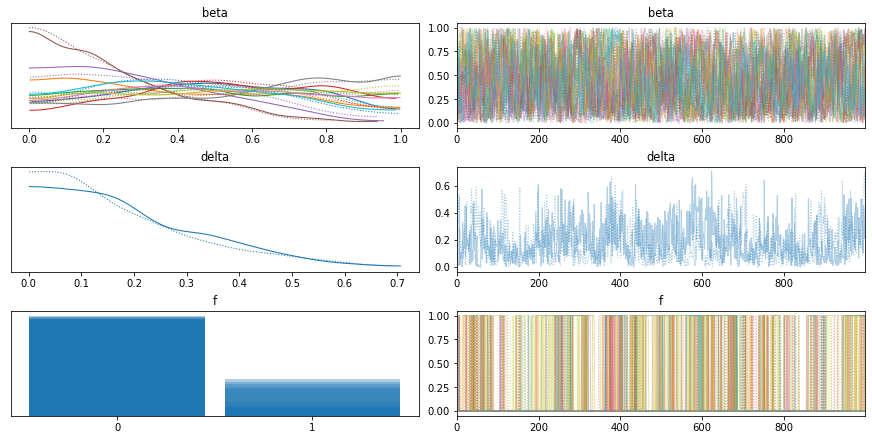

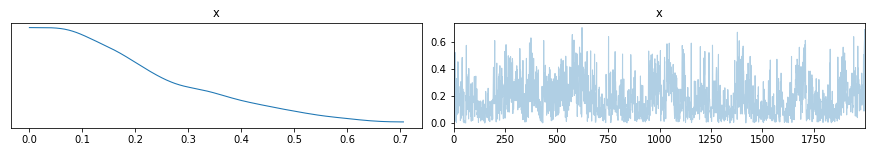

In [221]:
pm.traceplot(trace,var_names=["beta","delta","f"]);

In [235]:
trace['beta'].shape

(2000, 10)

In [222]:
trace['delta'].shape

(2000,)

In [223]:
trace['delta'].mean()

0.18387938230206763

In [224]:
hidden_delta

0.19710350524131587

In [225]:
print(trace['beta'].mean(axis=0))
print(hidden_beta)

[0.46204741 0.44078224 0.50017525 0.5106041  0.3307504  0.23315447
 0.50349097 0.58466669 0.52490439 0.44807444]
[0.00154601 0.35948712 0.13355926 0.52184209 0.78875548 0.18350556
 0.73114631 0.80189432 0.18260783 0.57180874]


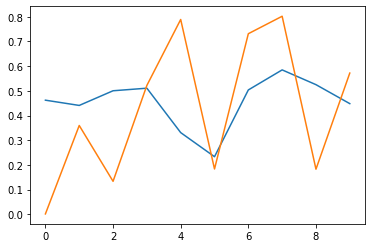

In [226]:
plot(trace['beta'].mean(axis=0))
plot(hidden_beta);

In [232]:
trace['f'].shape

(2000, 10)

In [227]:
st.mode(trace['f'])

ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), count=array([[1672, 1877, 1381, 1848, 1939, 1929, 1972, 1947, 1319, 1764]]))

In [229]:
hidden_f[:,1]

array([False, False, False, False, False, False, False, False,  True,
        True])

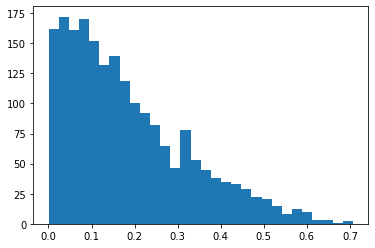

In [230]:
guessed_delta = trace['delta'].mean()
hist(trace['delta'],bins=30);